# Movie Revenue Analysis

## Introduction to the data

This data set (https://www.kaggle.com/narmelan/top-ten-blockbusters-20191977) contains details on top ten worldwide best performing movies from the year 1977 to 2019. Following features are included:

1. release_year: Year on which the movie was released
2. rankinyear: Rank of the movie in the given year
3. imdb_rating: Rating for the movie on IMDB
4. mpaa_rating: Motion picture rating
5. film_title: Name of the movie
6. film_budget: Budget in dollars
7. lengthinmin: Length of the movie in minutes
8. domestic_distributor: Agency/company that distributed the movie domestically
9. worldwide_gross: Worldwide gross revenue in dollars
10. domestic_gross: Domestic gross revenue in dollars
11. genre_1: Genre i.e. type of the movie e.g. horror, drama, etc.
12. genre_2: Other genre
13. genre_3: Other genre

The data is in a csv file. Let us load the data and peak into it


In [1]:
# Import necessary packages.
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('Blockbusters_2019-1977.csv')

Let us look at the data briefly.

In [2]:
data.shape

(430, 13)

We have 430 rows of observations over 13 features. Following list contains the data type of each feature.

In [3]:
data.dtypes

release_year              int64
rank_in_year              int64
imdb_rating             float64
mpaa_rating              object
film_title               object
film_budget               int64
length_in_min             int64
domestic_distributor     object
worldwide_gross           int64
domestic_gross            int64
genre_1                  object
genre_2                  object
genre_3                  object
dtype: object

It is clear that we have categorical features. They will have to be coded using one hot encoding.

Here are summary statistics for some selected variables.

In [4]:
display(pd.DataFrame(data.worldwide_gross.describe()))

,worldwide_gross
count,4.300000e+02
mean,4.993737e+08
std,3.966114e+08
min,3.718714e+07
25%,2.155117e+08
50%,3.800620e+08
75%,7.317081e+08
max,2.797801e+09


The unique levels of the categorical variable *mpaa_rating*. Note that this contain *NaN* which needs to be fixed.

In [5]:
pd.DataFrame(data.mpaa_rating.unique())

,0
0,PG-13
1,PG
2,G
3,R
4,NaN


The number of unique *domestic_distributor* levels are given below.

In [6]:
data.domestic_distributor.nunique()

25

-----------

## Objectives

The following list denotes the objectives for this project.

1. Data cleaning: Identifying limitations of data and fixing them.
3. Feature engineering and EDA: Transformation where necessary and brief EDA.
4. Modeling: Using modeling techniques to develop the best **predictive** model for the target variable. **Target variable** is **worldwide_gross**.
6. Summary: Key finds and summary.
7. Suggestions: Suggestions for further analysis.

## Data Cleaning  

This data set is in a quite clean state. Let us start by looking for missing values.

In [7]:
data.isna().sum()

release_year              0
rank_in_year              0
imdb_rating               0
mpaa_rating               1
film_title                0
film_budget               0
length_in_min             0
domestic_distributor      0
worldwide_gross           0
domestic_gross            0
genre_1                   0
genre_2                  21
genre_3                 106
dtype: int64

We can see that there is one *mpaa_rating* value missing. There are also 21 and 106 *genre_2* and *genre_3* values missing. Let us look at which movie is missing the *mpaa_rating* feature.

In [8]:
data[data.mpaa_rating.isna()].film_title

26    Wolf Warrior 2
Name: film_title, dtype: object

IMDB states that this movie is unrated. We can either create a new level "NR" for this movie or just delete this row. I believe if we create a new level, it would introduce an artificial effect on the data because this level will only be used by this single observation. Therefore, dropping this level is the best.

In [9]:
data.drop(index=26, inplace=True)

The absense of values in *genre_2* and *genre_3* columns are not problematic, because I do not intend to use those variables in the present study. The feature *genre_1* contains no missing values and therefore, good enough for analysis. This value contains the major genre of the movie.

Therefore, let us drop these two columns.

In [10]:
data.drop(columns=['genre_2', 'genre_3'], inplace=True)

Let us convert the dollar values into millions of dollars and round to two decimal points. This makes it easier to work with those values.

In [11]:
data["film_budget"] = data.film_budget.div(1000000).round(2)
data["worldwide_gross"] = data.worldwide_gross.div(1000000).round(2)
data["domestic_gross"] = data.domestic_gross.div(1000000).round(2)

## Feature engineering and EDA

### Log transformations

Let us look at some numerical features and there distributions.

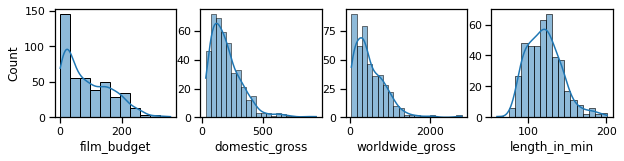

In [12]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')

fig, ax = plt.subplots(1,4)
fig.set_figwidth(10)
fig.set_figheight(2)

sns.histplot(data.film_budget, kde=True, label='All values', ax=ax[0])
sns.histplot(data.domestic_gross, kde=True, label='b', ax = ax[1]).set(ylabel='')
sns.histplot(data.worldwide_gross, kde=True, label='b', ax = ax[2]).set(ylabel='')
sns.histplot(data.length_in_min, kde=True, label='b', ax = ax[3]).set(ylabel='');

We find that all these variables, except *length_in_min* are right skewed, and therefore, need to be log transformed. The same can be observed by the skew data obtained below. Absolute skew values above 0.75 can be considered skewed.

In [13]:
skews = data.skew()
skews[skews > .75]

film_budget        0.769425
worldwide_gross    1.693160
domestic_gross     1.692143
dtype: float64

Log transforming *film_budge*, *domestic_gross*, and *worldwide_gross* features.

In [14]:
data.film_budget = data.film_budget.apply(np.log1p)
data.worldwide_gross = data.worldwide_gross.apply(np.log1p)
data.domestic_gross = data.domestic_gross.apply(np.log1p)

Let us look at the graphs after the transformations.

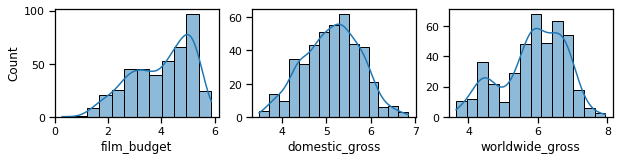

In [15]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(10)
fig.set_figheight(2)

sns.histplot(data.film_budget, kde=True, label='All values', ax=ax[0])
sns.histplot(data.domestic_gross, kde=True, label='b', ax = ax[1]).set(ylabel='')
sns.histplot(data.worldwide_gross, kde=True, label='b', ax = ax[2]).set(ylabel='');

### Linear relationships and multicollinearity

Let us look at pairwise correlations between the features (numerical).

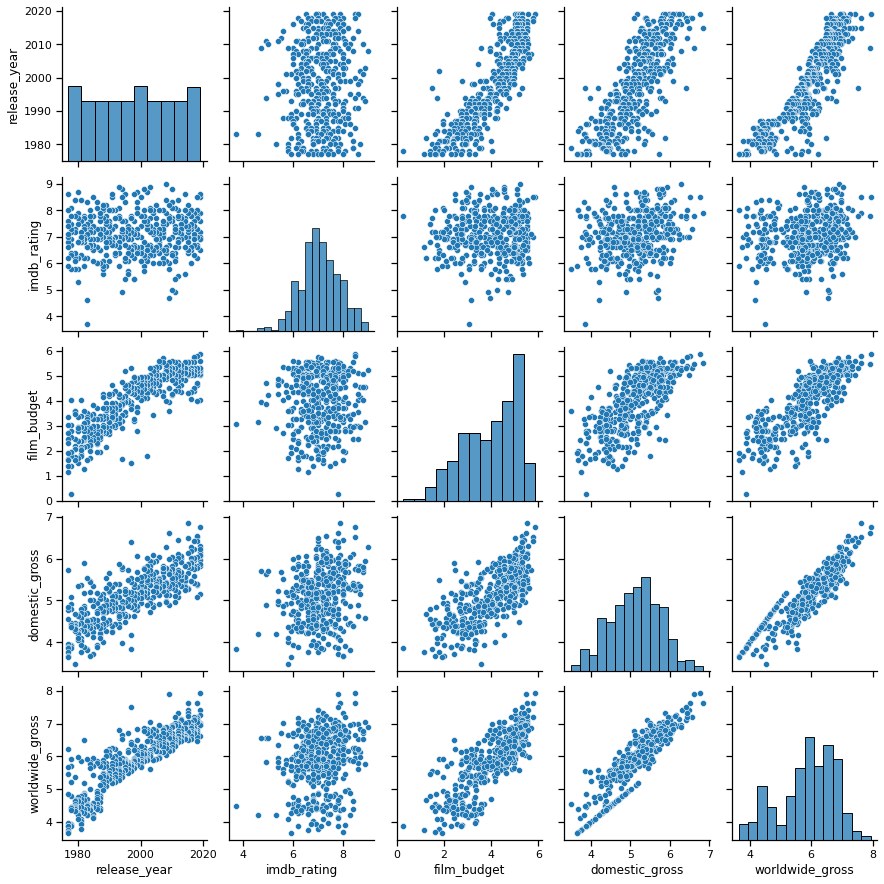

In [16]:
sns.pairplot(data, vars=['release_year', 'imdb_rating', 'film_budget', 
                         'domestic_gross', 'worldwide_gross']);

Our target, **worldwide_gross**, is linearly correlated with the features *release_year*, *film_budget*, and *domestic_gross*.

However, we can see considerable multicollinearity among these variables. For example, *domestic_gross* has a linear relationship with both *release_year* and *film_budget*. Therefore, for ordinary linear regression, it is better to remove this variable when carrying out multiple linear regression. 

However, in this project, we would use regularized methods, and therefore, we would not remove features at this stage.

### Polynomial features

Based on the pair plot above, there appears to be no need for using higher order polynomial transformations on this data. However, during the modeling, we would introduce such features.

### Encoding categorical features


The feature *film_title* is unique for each movie, and therefore, is useless to use in modeling. We need to drop it.

In [17]:
data.drop(columns = ['film_title'], inplace = True)


The following features are categorical and therefore, their levels need to be encoded into numerical features.

In [18]:
mask = data.dtypes == np.object
cat_cols = list(data.columns[mask])
', '.join(cat_cols)

'mpaa_rating, domestic_distributor, genre_1'

Let us start by label encoding i.e. converting string values into numericals, followed by one hot encoding as well as creating new column names for new columns.

In [19]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

le = LabelEncoder()
ohe = OneHotEncoder(drop = 'first')


for col in cat_cols:

    # Label transform. String levels of 'col' -> int levels.
    # dat is (num_rows, ) numpy array.
    dat = le.fit_transform(data[col]).astype(np.int)
    
    # Remove the original column from data frame.
    data = data.drop(col, axis=1)
    
    # One hot encode the data.
    # dat2 is a sparse matrix.
    dat2 = ohe.fit_transform(dat.reshape(-1,1))
    
    # Create new column names.
    n_cols = dat2.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]
    
    # Combine to create new data frame.
    dfnew = pd.DataFrame(dat2.toarray(), index = data.index, columns = col_names)

    data = pd.concat([data, dfnew], axis = 1)

## Modeling

Let us separate features and target columns.

In [20]:
y = data.worldwide_gross
x = data.drop('worldwide_gross', axis = 1)

### Simple linear regression

Let us start with simple linear regression. 

In [21]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

Let us carry out cross validation by splitting the data set into 3 groups. Apply standard scaler to the data as well.

In [22]:
# Create a k-fold validation object.
kf = KFold(shuffle=True, random_state=10853, n_splits=3)

# Scaler and linear regression.
s = StandardScaler()
lr = LinearRegression()

# Estimator is a pipeline combining both scaler and LR.
estimator = Pipeline([("scaler", s), ("regression", lr)])

Carry out cross validation and calculate the $R^2$.

In [23]:
predictions = cross_val_predict(estimator, x, y, cv = kf)

In [24]:
r2_score(y, predictions)

-1.6268447421133652e+22

Above $R^2$ value is abysmal i.e. the full model is totally incapable of explaining the relationship between the features and the target. Therefore, rather than looking to improve this model, we shall look at ridge regression.

### Ridge regression

In [25]:
from sklearn.model_selection import GridSearchCV

# New estimator for ridge regression.
estimator = Pipeline([("scaler", StandardScaler()), 
                      ("polynomial_features", PolynomialFeatures()), 
                      ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(1, 20, 30)
}

gridR = GridSearchCV(estimator, params, cv=kf, n_jobs=2)

Let us fit our data to the above cross validator.

In [26]:
gridR.fit(x, y)
gridR.best_params_

{'polynomial_features__degree': 1,
 'ridge_regression__alpha': 5.789922573134877}

According to the output, the best polynomial power is 1 i.e. no need for higher polynomial powers. The best alpha value (i.e. lambda) for penalty term in regularlization is 5.79.

Let us predict values for *x* using this model and calculate the $R^2$ value.

In [27]:
y_predict = gridR.predict(x)
r2_score(y, y_predict)

0.9495147197116247

An $R^2$ of 0.95 is excellent for prediction. Therefore, we have achieved a good model for explaining the target.

Looking at the coefficients of the features, we can see that most features make insignificant contribution to the final model.

In [28]:
gridR.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00,  3.61878090e-01, -1.80854583e-01,  9.15526249e-03,
        1.69553181e-01, -6.58601146e-03,  3.46352940e-01, -1.97381818e-02,
        1.53281349e-02,  1.50392146e-02, -1.22373218e-02,  3.29096477e-03,
        2.53726981e-03, -9.84420984e-03,  5.27008634e-02,  1.92563630e-02,
       -1.86514535e-03, -7.07891602e-03, -1.23594376e-03,  2.17753632e-02,
        3.15255440e-02,  8.19234435e-03, -1.51663977e-04,  4.42610166e-02,
        2.15235086e-02,  3.80801436e-03,  3.77308579e-02,  2.74955729e-02,
       -2.35795559e-02,  3.60321045e-02,  2.18141634e-02, -1.51647877e-02,
        1.73034277e-03,  2.11782855e-02,  2.94738879e-02,  6.78806703e-03,
       -5.50496368e-03,  4.49841272e-03,  1.91637234e-02,  1.17593971e-02,
        6.23773031e-03,  3.34777896e-02,  2.11662866e-02, -1.31987600e-02])

### Lasso regression

Let us carry out lasso regression as well. This is gives great results for an interpretable model. 

In [29]:
# Estimator for lasso regression.
estimator = Pipeline([("scaler", StandardScaler()), 
                      ("polynomial_features", PolynomialFeatures()), 
                      ("lasso_regression", Lasso())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'lasso_regression__alpha': np.geomspace(0.0001, 0.01, 20)
}

gridL = GridSearchCV(estimator, params, cv=kf, n_jobs=2)

Again, let us fit with this validator.

In [30]:
gridL.fit(x, y)
gridL.best_params_

{'lasso_regression__alpha': 0.007847599703514606,
 'polynomial_features__degree': 2}

In [31]:
y_predict = gridL.predict(x)
r2_score(y, y_predict)

0.9733512207277766

It is interesting to see that we have reached a model with a higher predictive power of $R^2$ of 0.97.

### Most important features

Let us use the results of lasso regression and fit the whole model (without splitting) in order to find out the most important features.

In [32]:
best_estimator = Pipeline([
                    ("scaler", StandardScaler()),
                    ("polynomial_features", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.00847))])

best_estimator.fit(x, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('polynomial_features', PolynomialFeatures()),
                ('lasso_regression', Lasso(alpha=0.00847))])

Following data frame depicts the 8 most important features of the model based on the values of the coefficients. It should be noted that the column labeled '0' gives the names of the feature (or interaction / polynomial), while the column names '1' gives the coefficient of that term. The names of the features as given under column '0' can be read from the "Feature Names" table.

`PolynomialFeatures()` also includes interactions. These are given as x1 x5.

In [33]:
imp_features = pd.DataFrame(zip(best_estimator.named_steps["polynomial_features"].get_feature_names(),
                                best_estimator.named_steps["lasso_regression"].coef_,
                           ))
imp_features.sort_values(by=1, ascending=False).head(6)

,0,1
1,x0,0.483018
6,x5,0.295474
4,x3,0.068229
87,x1^2,0.029674
211,x4 x5,0.025061
45,x0 x1,0.024862


In [34]:
col_names_dict = dict(zip(list(range(len(x.columns.values))), x.columns.values))

fnames = pd.DataFrame.from_dict(col_names_dict.items())

display('Feature Names (first 6 only)', fnames.head(6))

'Feature Names (first 6 only)'

,0,1
0,0,release_year
1,1,rank_in_year
2,2,imdb_rating
3,3,film_budget
4,4,length_in_min
5,5,domestic_gross


It is clear, by comparing the two tables above, that the most import features are release_year, domestic_gross, and film_budget.

## Summary

We were able to reach a model with a very high predictive power, as signified by the $R^2$ value. The most important features are *release_year*, *domestic_gross*, and *film_budget*. Interaction terms betwenn *length_in_min* and *domestic_gross* as well as that between *release_year* and *rank_in_year* can also be identified. Furthermore, the square of *rank_in_year* is also an important polynomial term in predicting the **worldwide_gross** value.

## Suggestions

One of the main attributes of the data set is that there are only around 10 movies per year. It is unclear how this "structure" might affect the analysis. Furthermore, the number of data points is also limited and therefore, a larger data set would be much suitable for a rigid analysis.